In [277]:
import pathlib
import cv2

import matplotlib.pyplot as plt
import numpy as np

In [278]:
folder = pathlib.Path('./../dataset/seq50rect2')
images = list(folder.iterdir())
images = [cv2.imread(str(img), cv2.IMREAD_GRAYSCALE) for img in images]

In [279]:
import config

In [280]:
camera_matrix = np.array(
    [[config.CAMERA_CALIBRATION[0], 0, config.CAMERA_CALIBRATION[2]],
    [0, config.CAMERA_CALIBRATION[1], config.CAMERA_CALIBRATION[3]],
    [0, 0, 1]]
)

In [281]:
good_ratio = 0.6

In [282]:
img1 = images[0] # queryImage
img2 = images[1] # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
# Apply ratio test
good = []

for m, n in matches:
    if m.distance < good_ratio * n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(
    img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

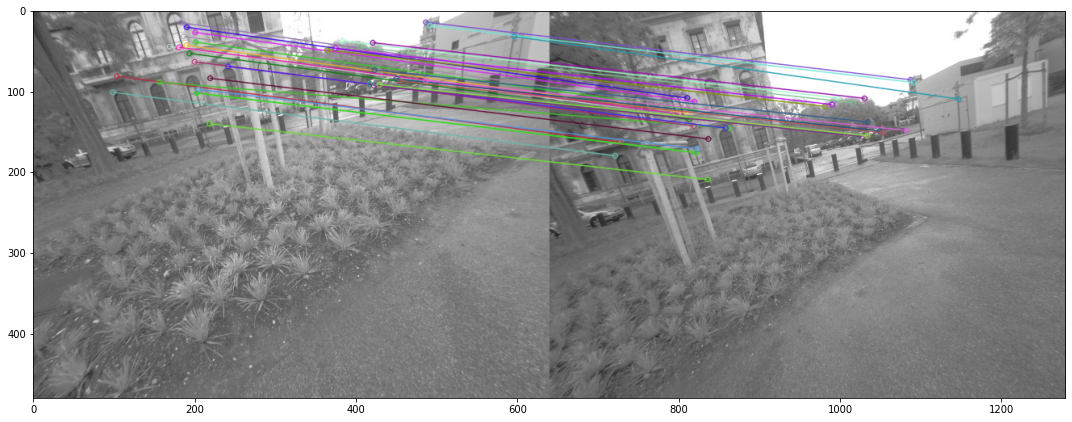

In [283]:
fig, ax = plt.subplots(1, 1)
ax.imshow(img3)
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

In [284]:
pts_im1 = [kp1[m[0].queryIdx].pt for m in good]
pts_im1 = np.array(pts_im1, dtype=np.float32).T
pts_im2 = [kp2[m[0].trainIdx].pt for m in good]
pts_im2 = np.array(pts_im2, dtype=np.float32).T

In [285]:
retval, mask = cv2.findHomography(pts_im1.T, pts_im2.T, cv2.RANSAC, 50.0)

In [286]:
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()
h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
img2 = cv2.polylines(img2,[np.int32(dst)], True, 255, 3, cv2.LINE_AA)

In [287]:
# img1c = cv2.imread()
# draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                    singlePointColor = None,
#                    matchesMask = matchesMask, # draw only inliers
#                    flags = 2)
# good = np.reshape(np.array(good), -1)
# img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
# plt.imshow(img3, 'gray'), plt.show()

In [288]:
# essential matrix

In [289]:
# https://stackoverflow.com/questions/31431047/3d-reconstruction-from-two-calibrated-cameras-where-is-the-error-in-this-pipel
# normalised coordinates ? also what to do with normals in decomposeHomographyMat?

def choose_points(src_pts, dst_pts, choices):
    if choices > src_pts.shape[0]:
        raise Exception(f'Invalid number of choices, max: {src_pts.shape[0]}')
    
    corrs = []
    choices = np.random.choice(src_pts.shape[0], size=choices, replace=False)
    for i in choices:
        corrs.append((src_pts[i], dst_pts[i]))
        # normalize points ?
    return np.array(corrs)

    
def find_projection_matrix(camera_matrix, src_pts, dst_pts, rot1, rot2, trans, choices=10):
    # creates projection matrix for the reference (first) camera
    rt_mat_orig = np.hstack((np.identity(3), np.zeros(3)[np.newaxis].T))
    projection_mat_orig = np.dot(camera_matrix, rt_mat_orig)
    
    solutions = []
    points = choose_points(src_pts, dst_pts, choices)
    combinations = [(rot1, trans), (rot1, -trans), (rot2, trans), (rot2, -trans)]
    for rot, t in combinations:
        # creates projection matrix for the second camera
        rt_mat_2nd = np.hstack((rot, t))
        projection_mat_2nd = np.dot(camera_matrix, rt_mat_2nd)
        
        pts_3d = cv2.triangulatePoints(
            projection_mat_orig, projection_mat_2nd, points[:, 0], points[:, 1]
        )
        uhomo_pts_3d = np.array([pts_3d[0]/pts_3d[3], pts_3d[1]/pts_3d[3], pts_3d[2]/pts_3d[3]])
        if np.any(uhomo_pts_3d[2, :] < 0):
            continue  # invalid solution, point is behind the camera

        solutions.append({
            'pro_mat_1st': projection_mat_orig,
            'pro_mat_2nd': projection_mat_2nd,
            't_vec': t,
            'rt_mat': rt_mat_2nd
        })
    if len(solutions) > 1:
        choices += 2
        return triangulate_points(
            camera_matrix, src_pts, dst_pts, rot1, rot2, trans, choices=choices
        )
    if not solutions:
        raise Exception('Couldnt find solution to point triangulation')
    return solutions[0]
    
    

In [290]:
# Essential matrix
E, mask = cv2.findEssentialMat(src_pts, dst_pts, camera_matrix, cv2.RANSAC, 0.9)

In [291]:
rot1, rot2, trans = cv2.decomposeEssentialMat(E)
solution = find_projection_matrix(camera_matrix, src_pts, dst_pts, rot1, rot2, trans, choices=2)
pts_3d = cv2.triangulatePoints(
    solution['pro_mat_1st'], solution['pro_mat_2nd'], src_pts, dst_pts
)

In [292]:
unhomo_pts_3d = (pts_3d.T / np.expand_dims(pts_3d.T[:, 3], axis=1))[:,0:3]

In [293]:
camera_1st = np.array([0, 0, 0])
camera_2nd = (camera_1st + solution['t_vec'].T)[0]

In [294]:
# Fundamental matrix
pinv_camera_t = np.linalg.pinv(camera_matrix.T)
pinv_camera = np.linalg.pinv(camera_matrix)
x = np.dot(pinv_camera_t, E)
F = np.dot(x, pinv_camera)

In [295]:
F2, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_LMEDS)

In [296]:
F

array([[-2.46044288e-04,  2.25289197e-03, -1.31909890e+00],
       [-1.24376540e-04, -4.74825147e-05,  5.56235981e-02],
       [ 1.20829119e+00, -4.26469776e-01,  2.39388857e-01]])

In [297]:
F2

array([[-3.10759225e-06,  4.19193168e-05, -1.24976191e-02],
       [-4.22994415e-05,  1.09091732e-05, -1.07045717e-02],
       [ 1.55533261e-02,  6.29709574e-03,  1.00000000e+00]])

In [298]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1[0]), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2[0]), 5, color, -1)
    return img1,img2

<ipython-input-298-63a90952f9bf>:12: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img1 = cv2.circle(img1, tuple(pt1[0]), 5, color, -1)
<ipython-input-298-63a90952f9bf>:13: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img2 = cv2.circle(img2, tuple(pt2[0]), 5, color, -1)


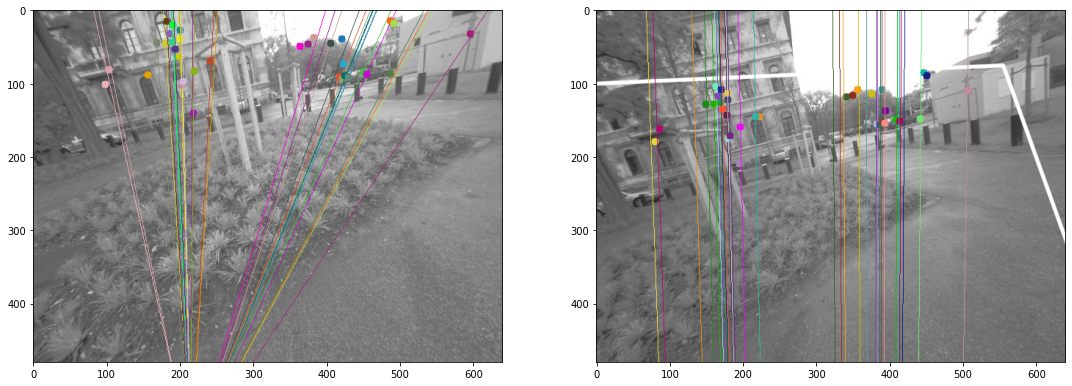

In [299]:
lines1 = cv2.computeCorrespondEpilines(dst_pts.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5, img6 = drawlines(img1, img2, lines1, src_pts, dst_pts)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(src_pts.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img3, img4 = drawlines(img2, img1, lines2, dst_pts, src_pts)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img5)
ax[1].imshow(img3)
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

In [300]:
# show where 3d points are and where camera is
# try other images